##### **Максимов Антон, Мартиросян Елизавета**

In [ ]:
!pip install gensim tqdm tmtoolkit pymorphy2 stop_words

In [ ]:
!pip install pyLDAvis==2.1.2
!pip install --upgrade gensim

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import json
import os
import warnings
import progressbar
import time
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from nltk.corpus import stopwords
from tqdm import tqdm

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import gensim
import stop_words
import re
import string
import pymorphy2

In [ ]:
%matplotlib inline
pyLDAvis.enable_notebook()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", None, "display.max_columns", None)
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
PATH_TO_CATALOGS = '/content/catalogs/'
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
local_download_path = os.path.expanduser(PATH_TO_CATALOGS)
try:
  os.makedirs(local_download_path)
except:
  pass
 
file_list = drive.ListFile({'q': "'1llnTKbNJqRABPC5IWNCYkrboZ9fJhK3k' in parents"}).GetList()
 
for f in file_list:
  fname = os.path.join(local_download_path, f['title'])
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

# Лабораторная работа #3

Имеем два датасета: англоязычный (4085 документов и 4 категории), русскоязычный (20359 документов и 6 категорий). 

Работа состоит из 4 частей: загрузка данных, построение LDA моделей, построение PLSA моделей, общий вывод. Каждая часть разбита на две под части: для англоязычного и русскоязычного датасета.

## Загрузка данных

Загружаем данные (текст, теги предобработанные):

### English-language dataset

In [ ]:
articles_eng = np.array([])

In [ ]:
with open(PATH_TO_CATALOGS + 'catalog_eng.json', 'r', encoding='utf8') as data:
    articles_eng = np.hstack((articles_eng, json.loads(data.read())['catalog']))

In [ ]:
texts_eng = [article['filtered_text'] for article in articles_eng]
categories_eng = [article['category'] for article in articles_eng]
tags_eng = [article['filtered_tags'] for article in articles_eng]

In [ ]:
stopwords_set = set(stopwords.words('english'))

# clear stopwords for texts

texts_eng_ = []
for text in texts_eng:
    x = []
    for word in text.split():
        if word not in stopwords_set:
            x.append(word)
    texts_eng_.append(' '.join(x))
texts_eng = texts_eng_.copy()

# clear stopwords for tags

all_tags = []
for tag in tags_eng:
    for i in tag:
        for j in i['value'].split():
            all_tags.append(j)

all_tags_ = []
for tag in all_tags:
    if tag not in stopwords_set:
        all_tags_.append(tag)
all_tags = all_tags_.copy()

### Russian-language dataset

In [ ]:
df = pd.read_csv('preprocessed.csv')
df.head()

article_id  ...                                      filtered_text
0         https://lenta.ru/news/2020/06/22/enlarge/  ...  экономист константин юрченко перечислить спосо...
1             https://lenta.ru/news/2020/06/08/oil/  ...  цена нефть подскочить максимум начало март сви...
2  https://lenta.ru/news/2020/06/29/finansirovanie/  ...  министерство финансы россия намерить сократить...
3            https://lenta.ru/news/2020/07/06/zvzd/  ...  судостроительный комплекс звезда приступить ст...
4         https://lenta.ru/news/2020/07/20/perevod/  ...  перевод машина бензин газ стать процент дешёвы...

[5 rows x 7 columns]

## LDA

Реализацию LDA взяли из [gensim](https://radimrehurek.com/gensim/models/ldamodel.html).

Построили для различного числа топиков.

In [ ]:
def get_lda_models(texts, num_topics_list):
    
    c_w2v_values, c_v_values = [], []
    models = []
    
    texts_tokenize = [nltk.word_tokenize(text) for text in texts]
    common_dictionary = Dictionary(texts_tokenize)
    common_corpus = [common_dictionary.doc2bow(text) for text in texts_tokenize]
    
    model = gensim.models.Word2Vec(texts_tokenize)
    word_vectors = model.wv    
    
    for num_topics in tqdm(num_topics_list):
        lda_model_coh = gensim.models.ldamodel.LdaModel(corpus=common_corpus,
                                                        id2word=common_dictionary,
                                                        num_topics=num_topics, 
                                                        passes=90)
        models.append(lda_model_coh)
        c_w2v_lda = CoherenceModel(model=lda_model_coh, texts=texts_tokenize,
                                             dictionary=common_dictionary, coherence = 'c_w2v', 
                                             keyed_vectors=word_vectors)
        c_v_lda = CoherenceModel(model=lda_model_coh, texts=texts_tokenize,
                                 dictionary=common_dictionary, coherence = 'c_v')
        c_w2v_values.append(c_w2v_lda.get_coherence())
        c_v_values.append(c_v_lda.get_coherence())

    return models, c_w2v_values, c_v_values

### English-language dataset

Натренируем LDA модели для различного числа топиков: 4, 20, 40, 80.

In [ ]:
result_lda_eng = get_lda_models(texts_eng, [4, 20, 40, 60])


100%|██████████| 4/4 [1:04:07<00:00, 961.97s/it]


Результаты:

In [ ]:
data = []
for i in range(len(result_lda_eng[0])):
    data.append([result_lda_eng[0][i], result_lda_eng[1][i], result_lda_eng[2][i]])
pd.DataFrame(data, columns=['Model', 'coherence=c_w2v', 'coherence=c_v'])

Model  \
0  LdaModel(num_terms=61224, num_topics=4, decay=0.5, chunksize=2000)    
1  LdaModel(num_terms=61224, num_topics=20, decay=0.5, chunksize=2000)   
2  LdaModel(num_terms=61224, num_topics=40, decay=0.5, chunksize=2000)   
3  LdaModel(num_terms=61224, num_topics=60, decay=0.5, chunksize=2000)   

   coherence=c_w2v  coherence=c_v  
0  0.419814         0.422668       
1  0.586886         0.518221       
2  0.641821         0.507587       
3  0.669779         0.522984

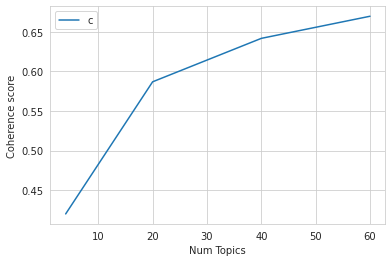

In [ ]:
plt.plot([4, 20, 40, 60], [result_lda_eng[1][i] for i in range(4)])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Самая лучшая модель последняя модель (с 60 топиками).

#### Визуализация лучшей модели

In [ ]:
texts_tokenize_eng  = [article.split() for article in texts_eng]
dictionary_eng = Dictionary(texts_tokenize_eng)
corpus_eng = [dictionary_eng.doc2bow(text) for text in texts_tokenize_eng]

Натренируем модель с 60 топиков:

In [ ]:
model = gensim.models.Word2Vec(texts_tokenize_eng)
word_vectors = model.wv    

In [75]:
lda60 = gensim.models.ldamodel.LdaModel(corpus=corpus_eng,
                                        id2word=dictionary_eng,
                                        num_topics=60, 
                                        passes=1, chunksize=10)

coherence:

In [76]:
c_w2v_lda = CoherenceModel(model=lda60, texts=texts_tokenize_eng,
                                        dictionary=dictionary_eng, coherence = 'c_w2v', 
                                        keyed_vectors=word_vectors)
c_v_lda = CoherenceModel(model=lda60, texts=texts_tokenize_eng,
                            dictionary=dictionary_eng, coherence = 'c_v')
c_w2v_lda.get_coherence(),   c_v_lda.get_coherence()

(0.6606961, 0.40409764979525514)

In [77]:
pyLDAvis.gensim.prepare(lda60, corpus_eng, dictionary_eng, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
58     0.409599  0.378082  1       1        25.579037
20     0.514741  0.177993  2       1        19.689812
8      0.555478  0.078225  3       1        11.671587
57     0.561278 -0.035634  4       1        11.204349
7      0.474230  0.252446  5       1        7.168589 
25     0.457910 -0.106233  6       1        4.669158 
46     0.398198  0.343447  7       1        3.876267 
1      0.395192 -0.437870  8       1        2.727832 
45     0.276493  0.424894  9       1        2.502398 
51     0.008396  0.519648  10      1        2.197641 
26     0.465574 -0.341051  11      1        2.121780 
19     0.418146  0.038175  12      1        1.280727 
41     0.098200  0.411628  13      1        0.868206 
13     0.132045 -0.402902  14      1        0.691046 
16     0.035680 -0.041640  15      1        0.609475 
39    -0.254133  0.065730  16      1        0.575361 
2     -0.140887  0.350824  17      1        0.494469 
31    -0.259895  0.284682  18      1        0.474225 
15    -0.096271 -0.244984  19      1        0.257261 
11    -0.184519 -0.374683  20      1        0.176516 
40    -0.119880  0.007991  21      1        0.148975 
55    -0.101931  0.191253  22      1        0.113583 
9      0.105539 -0.240625  23      1        0.111938 
54    -0.152263 -0.167768  24      1        0.105974 
44    -0.007002 -0.165032  25      1        0.105088 
47    -0.173090  0.076069  26      1        0.103482 
28    -0.317009 -0.038072  27      1        0.090800 
5     -0.198049 -0.066843  28      1        0.066756 
38    -0.096549 -0.129450  29      1        0.043177 
36    -0.096180  0.040561  30      1        0.036749 
59    -0.061937  0.003803  31      1        0.035668 
21    -0.123927 -0.056879  32      1        0.033257 
30    -0.098586 -0.011705  33      1        0.017406 
12    -0.068744 -0.034396  34      1        0.015403 
56    -0.094057 -0.040383  35      1        0.015215 
4     -0.106472 -0.028372  36      1        0.004832 
3     -0.106472 -0.028372  37      1        0.004832 
14    -0.106472 -0.028372  38      1        0.004832 
10    -0.106472 -0.028372  39      1        0.004832 
17    -0.106472 -0.028372  40      1        0.004832 
6     -0.106472 -0.028372  41      1        0.004832 
29    -0.106472 -0.028372  42      1        0.004832 
18    -0.106472 -0.028372  43      1        0.004832 
22    -0.106472 -0.028372  44      1        0.004832 
53    -0.106472 -0.028372  45      1        0.004832 
52    -0.106472 -0.028372  46      1        0.004832 
50    -0.106472 -0.028372  47      1        0.004832 
49    -0.106472 -0.028372  48      1        0.004832 
48    -0.106472 -0.028372  49      1        0.004832 
43    -0.106472 -0.028372  50      1        0.004832 
42    -0.106472 -0.028372  51      1        0.004832 
37    -0.106472 -0.028372  52      1        0.004832 
35    -0.106472 -0.028372  53      1        0.004832 
34    -0.106472 -0.028372  54      1        0.004832 
33    -0.106472 -0.028372  55      1        0.004832 
32    -0.106472 -0.028372  56      1        0.004832 
27    -0.106472 -0.028372  57      1        0.004832 
24    -0.106471 -0.028372  58      1        0.004832 
23    -0.106472 -0.028372  59      1        0.004832 
0     -0.106472 -0.028372  60      1        0.004832 , topic_info=                  Term          Freq         Total Category  logprob  loglift
1736   mr               55104.000000  55104.000000  Default  30.0000  30.0000
1128   said             68804.000000  68804.000000  Default  29.0000  29.0000
737    trump            25429.000000  25429.000000  Default  28.0000  28.0000
1168   state            38536.000000  38536.000000  Default  27.0000  27.0000
767    wa               66900.000000  66900.000000  Default  26.0000  26.0000
259    election         17320.000000  17320.000000  Default  25.0000  25.0000
562    president        14541.000000  14541.000000  Default  24

Трудно что-то сказать, так как много топиков. Но выделены достаточно узкие "темы", которые можно с чем-либо ассоциировать. Например топик 3 явно о политике; топик 18 связан скорее всего со спортом; 8 топик о выборах (ключевые слова президент, Трамп, выборы); топик 13 (о работе, скорее всего из категории бизнеса); топик 15 явно о из категории art; топик 10 о семье и взаимоотношениях; топик 16 о музыке (входило в категорию art).

#### Поиск соответствий

(рассматриваем лучшую модель)

**Ground truth категории : 'sport', 'buisness', 'art', 'politics'**

In [78]:
texts_tokenize_eng  = [article.split() for article in texts_eng]
dictionary_eng = Dictionary(texts_tokenize_eng)
corpus_eng = [dictionary_eng.doc2bow(text) for text in texts_tokenize_eng]

In [79]:
model_w2v = gensim.models.Word2Vec(texts_tokenize_eng)
word_vectors = model_w2v.wv

In [80]:
all_tags_processed = []
for tag in all_tags:
  if tag in model_w2v.wv.vocab:
    all_tags_processed.append(all_tags[all_tags.index(tag)])

In [81]:
topn_words = {i: [word for word, prob in lda60.show_topic(i, topn=lda60.num_topics)] for i in range(0, lda60.num_topics)}

Категория политика:

In [103]:
topn_words[57][:20]

['ballot',
 'state',
 'election',
 'party',
 'race',
 'voting',
 'american',
 'mail',
 'justice',
 'ha',
 'supporter',
 'black',
 'former',
 'country',
 'support',
 'also',
 'political',
 'right',
 'issue',
 'white']

In [104]:
similarity = word_vectors.n_similarity([word for word in topn_words[57] if word in model_w2v.wv.vocab], ['politics'])
print(f"{similarity:.4f}")

0.4013


Категория спорт:

In [105]:
topn_words[31][:20]

['facebook',
 'event',
 'virtual',
 'online',
 'platform',
 'medium',
 'ticket',
 'corporate',
 'afterward',
 'stream',
 'donate',
 'revenue',
 'video',
 'masked',
 'venue',
 'audience',
 'fan',
 'crew',
 'pay',
 'livestream']

In [106]:
similarity = word_vectors.n_similarity(topn_words[31], ['sport'])
print(f"{similarity:.4f}")

0.3967


Категория арт:

In [107]:
topn_words[40][:20]

['theater',
 'dance',
 'adjustment',
 'dancing',
 'artistic',
 'danced',
 'dancer',
 'video',
 'ballet',
 'company',
 'music',
 'new',
 'stage',
 'performance',
 'broadway',
 'work',
 'city',
 'york',
 'director',
 'body']

In [108]:
similarity = word_vectors.n_similarity(topn_words[40], ['art'])
print(f"{similarity:.4f}")

0.5111


Категория бизнес:

In [109]:
topn_words[41][:20]

['job',
 'advantage',
 'employee',
 'hoping',
 'work',
 'deeply',
 'guide',
 'intense',
 'pay',
 'guideline',
 'chose',
 'per',
 'level',
 'diverse',
 'identify',
 'affected',
 'working',
 'practice',
 'reflecting',
 'notion']

In [110]:
similarity = word_vectors.n_similarity(topn_words[41], ['business'])
print(f"{similarity:.4f}")

0.4184


Коэффициенты схожести категорий с топиками неплохие, учитывая, что количество категорий очень большое.

**Сравнение тегов и найденных тем**

In [89]:
data = []
for i in range(len(topn_words)):
    try:
        data.append([i, topn_words[i], all_tags_processed, word_vectors.n_similarity(topn_words[i], all_tags_processed)])
    except:
        pass
pd.DataFrame(data, columns=['num', 'Topics in model', 'all_tags_processed', 'similarity'])

num  \
0   1     
1   2     
2   7     
3   8     
4   11    
5   13    
6   15    
7   16    
8   19    
9   20    
10  25    
11  26    
12  31    
13  39    
14  40    
15  41    
16  45    
17  46    
18  47    
19  51    
20  57    
21  58    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Topics in model  \
0   [trump, president, election, white, presidential, day, news, house, rally, night, political, ha, four, donald, several, cast, final, fact, minute, past, fire, medium, breaking, watching, died, second, series, arguing, conversation, last, man, aired, hour, scene, expects, episode, show, star, none, seen, time, dallas, first, wild, one, also, history, story, trying, favorite, tv, right, yet, reality, plot, turn, run, anything, two, seven]                                                               
1   [joe, television, 49, host, show, audience, viewer, tv, looming, popular, camera, costume, comedy, live, producer, air, watched, night, character, crafted, episode, animated, joke, fan, creator, storytelling, like, even, many, quality, crowd, amazing, one, produced, make, pandemic, inside, fear, emotion, social, funny, double, moment, time, player, question, ha, year, people, instead, week, wa, day, role, far, stand, le, stage, big, person]                                                           
2   [like, going, people, get, think, know, thing, want, day, ha, see, u, lot, one, make, would, much, go, way, feel, say, need, time, every, really, still, anything, even, something, good, might, take, little, many, getting, could, come, hear, kind, different, year, done, got, mind, look, always, old, back, course, away, moment, place, love, trying, happen, work, let, reading, doe, keep]                                                                                                                    
3   [state, ha, percent, 000, million, would, district, week, according, could, number, result, last, government, year, month, case, voted, count, new, pandemic, even, many, also, service, country, report, united, recent, coronavirus, national, business, company, still, may, plan, worker, public, data, term, nearly, large, far, day, since, evidence, information, system, operation, threat, across, le, 1, said, washington, end, announced, chief, thousand, yet]                                             
4   [vice, schedule, season, host, apple, hosting, nov, judy, ahead, 12, night, 9, start, new, featuring, broadcast, 11, play, 1940s, 3, 23, 30, 8, series, coming, look, time, special, return, final, 7, end, 27, four, last, december, winter, history, sept, take, president, road, six, landscape, try, five, april, include, question, modern, 2, change, list, classic, pandemic, begin, david, two, first, star]                                                                                                   
5   [city, resident, site, place, neighborhood, street, urban, maintain, community, domestic, building, traffic, new, park, construction, apply, york, center, monument, space, brooklyn, built, statue, st, indoors, sign, across, accessible, large, block, outdoors, design, cart, orange, south, visit, people, small, century, creating, filled, air, seen, central, inside, plan, yorker, life, like, remains, harlem, work, one, example, gray, view, offer, around, become, day]                                   
6   [2008, amazing, died, angst, 34, tour, billboard, ease, consecutive, band, metal, sheer, boundary, tribute, trip, wild, scene, shape, breaking, record, tradition, several, version, year, rec

Коэффициенты схожести тегов с топиками варьируются в среднем от 0.5 до 0.6, что неплохо и в целом ключевые слова достаточно хорошо описывают категории.

### Russian-language dataset

In [ ]:
common_texts  = [article.split() for article in list(df['filtered_text'])]
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

**word2vec model**:

In [ ]:
model_w2v = gensim.models.Word2Vec(common_texts)
word_vectors = model_w2v.wv

**Подсчет coherence**:

In [ ]:
def coherence_score(model):
  coherence_model_lda = CoherenceModel(model=model, texts=common_texts, dictionary=common_dictionary, coherence = 'c_w2v', 
                                       keyed_vectors=word_vectors)
  score = coherence_model_lda.get_coherence()
  #print("Coherence: ", score)
  return score

def coherence_score_cv(model):
  coherence_model_lda = CoherenceModel(model=model, texts=common_texts, dictionary=common_dictionary, coherence = 'c_v')
  score = coherence_model_lda.get_coherence()
  #print("Coherence: ", score)
  return score

In [ ]:
models = []
for i in progressbar.progressbar(range(6,60)):
    models.append(gensim.models.ldamodel.LdaModel(corpus = common_corpus, id2word=common_dictionary, 
                                                  num_topics = i, update_every=1,random_state=100,
                                                  passes=1, alpha='auto', chunksize=100
                                                  ))
    time.sleep(0.02)

100% (54 of 54) |########################| Elapsed Time: 1:16:38 Time:  1:16:38


In [ ]:
n_topics = list(range(6,60))
coherence_values = []
for i in range(len(models)):
  coherence_values.append([coherence_score(models[i]), n_topics[i]])
  time.sleep(0.02)

**Выберем 4 лучших модели, и снова натренируем их с другими парметрами, но с таким же кол-м топиков**:

In [ ]:
sorted(coherence_values, reverse=True)[:4]

[[0.5148414, 46], [0.51443636, 14], [0.5125964, 40], [0.5110518, 20]]

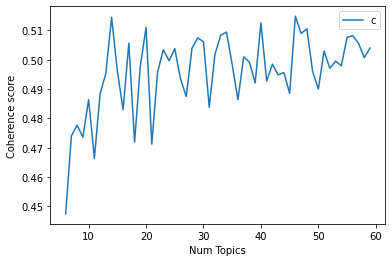

In [ ]:
x = range(6,60,1)
plt.plot(x, [row[0] for row in coherence_values])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

####**MODEL #1 (14 topics)**

Данная модель является лучшей среди 4, поэтому на примере этой модели сделаем краткий анализ.

In [ ]:
LDA14 = gensim.models.ldamodel.LdaModel(corpus = common_corpus, id2word=common_dictionary,
                                       num_topics = 14, random_state=100, update_every=1, 
                                       chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
LDA14.print_topics()

[(0,
  '0.037*"ведущий" + 0.029*"россия" + 0.026*"программа" + 0.021*"проект" + 0.018*"российский" + 0.015*"компания" + 0.013*"новый" + 0.012*"зритель" + 0.011*"страна" + 0.009*"пресс"'),
 (1,
  '0.048*"инцидент" + 0.032*"выложить" + 0.025*"нагорный" + 0.025*"карабах" + 0.024*"жаловаться" + 0.023*"азербайджан" + 0.022*"остров" + 0.021*"армения" + 0.015*"турция" + 0.014*"участок"'),
 (2,
  '0.062*"ходить" + 0.041*"неожиданный" + 0.038*"грозить" + 0.029*"воскресение" + 0.027*"определять" + 0.021*"индия" + 0.017*"пустить" + 0.016*"бен" + 0.016*"латвия" + 0.015*"нарушитель"'),
 (3,
  '0.032*"комментарий" + 0.029*"объяснить" + 0.029*"владимир" + 0.026*"россия" + 0.022*"российский" + 0.020*"познер" + 0.018*"путин" + 0.018*"интервью" + 0.016*"президент" + 0.015*"соловьёв"'),
 (4,
  '0.098*"обнаружить" + 0.096*"пара" + 0.060*"тест" + 0.040*"президентский" + 0.038*"байден" + 0.029*"лежать" + 0.029*"джо" + 0.027*"килограмм" + 0.021*"мясо" + 0.020*"курс"'),
 (5,
  '0.033*"youtube" + 0.033*"сша" +

In [ ]:
pyLDAvis.gensim.prepare(LDA14, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.267577  0.055464       1        1  26.702315
0      0.208572  0.074707       2        1  14.788521
9      0.173435 -0.167695       3        1  13.408863
11     0.141129  0.230818       4        1   9.794036
3      0.157696 -0.181558       5        1   9.112474
5      0.109820  0.024026       6        1   6.802879
7      0.072380 -0.193158       7        1   6.274435
8      0.005651  0.241947       8        1   3.613732
6     -0.125797  0.038681       9        1   3.337752
1     -0.204137 -0.010650      10        1   2.125730
13    -0.078237 -0.121432      11        1   1.939019
4     -0.222912  0.004177      12        1   0.952930
12    -0.247965  0.001835      13        1   0.722755
2     -0.257214  0.002839      14        1   0.424558, topic_info=              Term          Freq         Total Category  logprob  loglift
350         тысяча  10259.000000  10259.000000  Default  30.0000  30.0000
106        миллион   9756.000000   9756.000000  Default  29.0000  29.0000
5136  пользователь   9020.000000   9020.000000  Default  28.0000  28.0000
601    коронавирус  10826.000000  10826.000000  Default  27.0000  27.0000
2762       ведущий  16615.000000  16615.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
857            оаэ     56.784502     58.153817  Topic14  -5.1722   5.4380
680        пробить     48.967064     50.336382  Topic14  -5.3203   5.4343
1985       союзник     42.299632     43.668945  Topic14  -5.4667   5.4300
2121        альянс     41.299408     42.668718  Topic14  -5.4906   5.4293
2431    сдерживать     39.644699     41.014017  Topic14  -5.5315   5.4279

[584 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17082      8  0.998461    comedy
1244       4  0.999651     covid
1175       6  0.999205     daily
2721       8  0.999218  facebook
2899       9  0.997801    forbes
...      ...       ...       ...
366        1  0.267244  являться
366        2  0.590050  являться
366        3  0.010028  являться
366        4  0.129285  являться
366        5  0.002981  являться

[753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 10, 12, 4, 6, 8, 9, 7, 2, 14, 5, 13, 3])

В топике "коронавирус" наибольшее значение имеет слово коронавирус, что очевидно, однако в топике 7 про аварию Ефремова наибольший вес имее слово "врач".

**Сoherence Score**

In [ ]:
coherence_score(LDA14)

Coherence:  0.5205846


0.5205846

При увеличения параметра passes coherence_score уменьшался, поэтому passes=10 и лучше мы ничего не подобрали.

**Облако тегов для каждого топика**

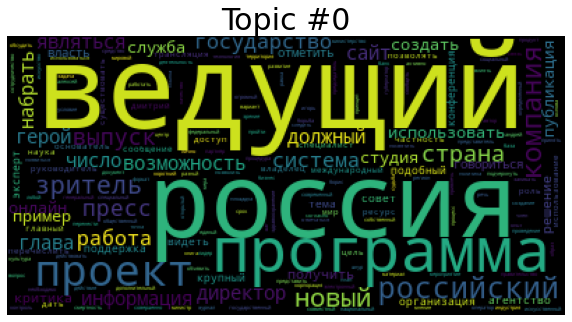

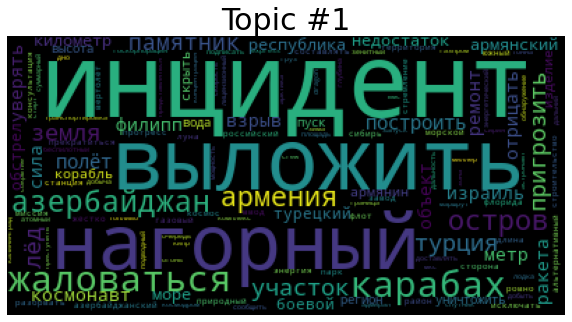

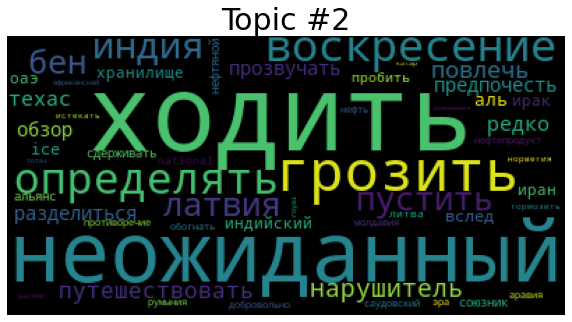

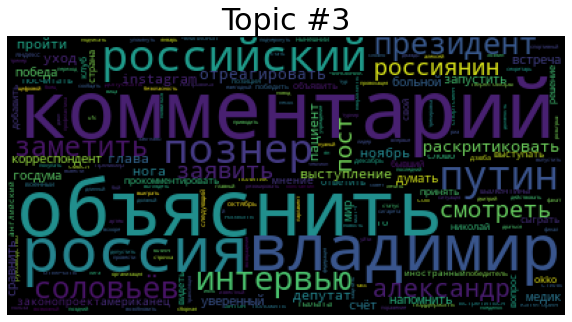

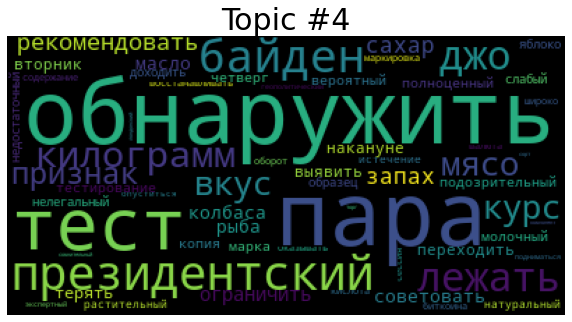

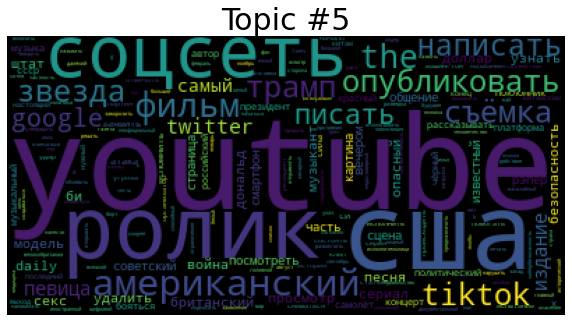

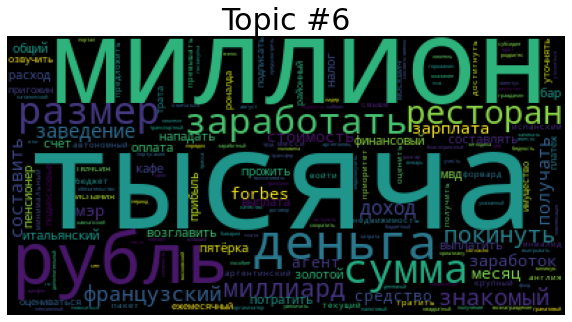

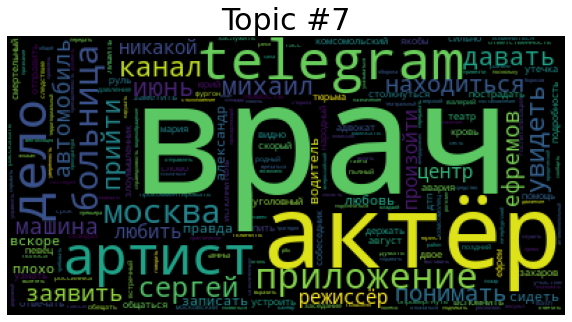

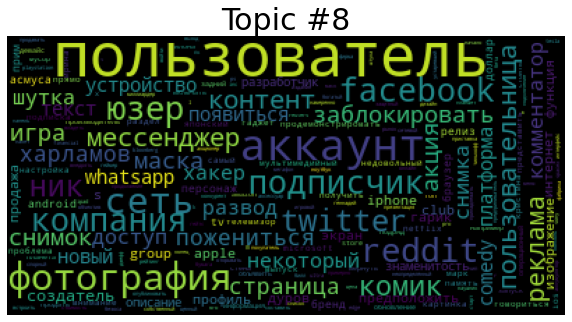

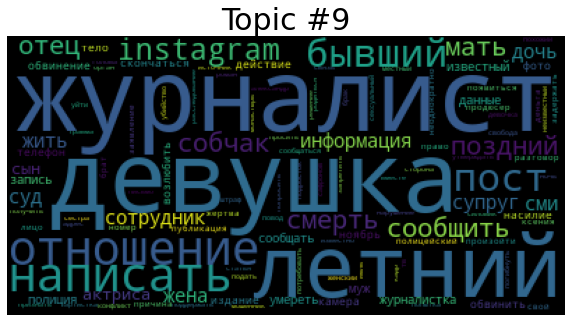

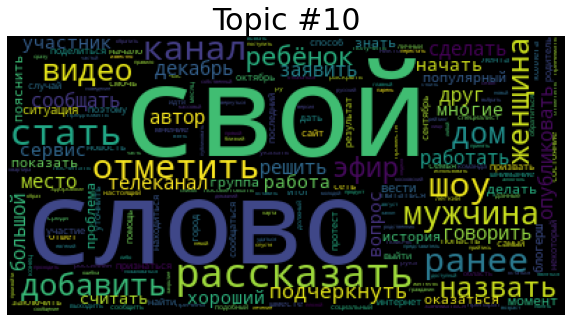

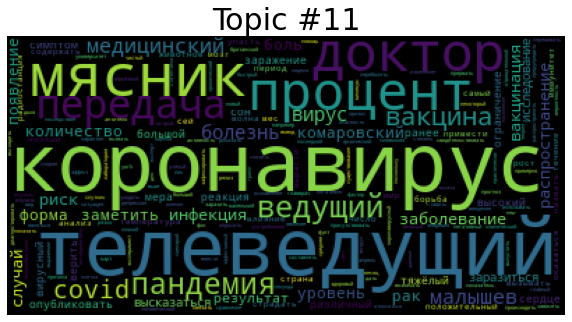

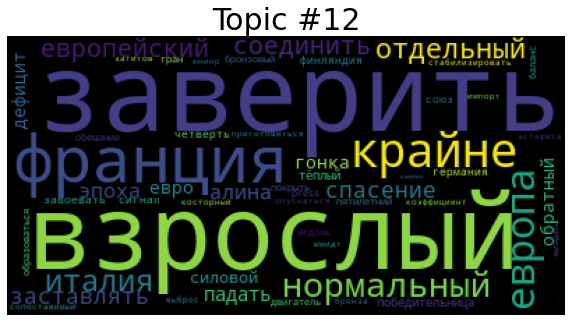

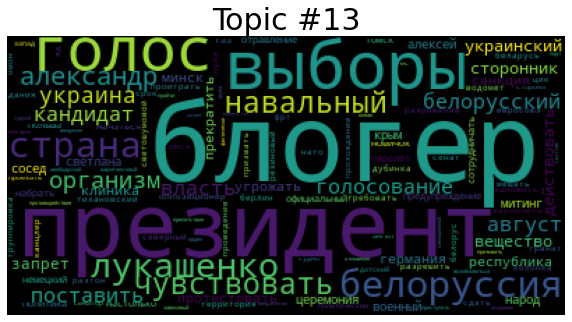

In [ ]:
for t in range(LDA14.num_topics):
    plt.figure(figsize= (10,10))
    plt.imshow(WordCloud().fit_words(dict(LDA14.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t), fontsize= 30)
    plt.show()

####**MODEL #2 (20 topics)**

In [ ]:
LDA20 = gensim.models.ldamodel.LdaModel(corpus = common_corpus, id2word=common_dictionary,
                                       num_topics = 28, random_state=100, update_every=1, 
                                       chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
LDA20.print_topics()

[(26,
  '0.093*"легко" + 0.044*"пустить" + 0.032*"петербургский" + 0.023*"ровно" + 0.018*"условный" + 0.015*"красноярский" + 0.015*"превышение" + 0.014*"образоваться" + 0.012*"купюра" + 0.010*"сдерживать"'),
 (16,
  '0.311*"вакцина" + 0.081*"игорь" + 0.032*"коллективный" + 0.023*"вполне" + 0.020*"ким" + 0.019*"исполнительный" + 0.019*"восток" + 0.018*"хранение" + 0.016*"коридор" + 0.011*"юг"'),
 (2,
  '0.069*"грозить" + 0.053*"душа" + 0.038*"невозможность" + 0.032*"предречь" + 0.030*"переходить" + 0.030*"падать" + 0.029*"бен" + 0.023*"списать" + 0.020*"неопределённый" + 0.019*"техас"'),
 (23,
  '0.071*"судебный" + 0.069*"республика" + 0.062*"сосед" + 0.056*"законодательство" + 0.047*"польша" + 0.041*"оставлять" + 0.038*"поступать" + 0.036*"проиграть" + 0.020*"польский" + 0.020*"разбирательство"'),
 (24,
  '0.382*"интернет" + 0.075*"игрок" + 0.066*"мобильный" + 0.027*"трафик" + 0.022*"пакет" + 0.020*"мтс" + 0.013*"салон" + 0.013*"скидка" + 0.010*"выработка" + 0.005*"спутниковый"'),
 (4,

In [ ]:
pyLDAvis.gensim.prepare(LDA20, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22     0.306546  0.218456       1        1  22.450387
20     0.273608  0.137582       2        1  14.323659
18     0.251231  0.014079       3        1  12.632776
7      0.264953  0.205994       4        1  11.951585
8      0.161585 -0.117934       5        1   5.873244
11     0.130070 -0.069205       6        1   4.816695
3      0.152084 -0.220729       7        1   4.517702
15     0.044149 -0.044495       8        1   2.504686
25     0.088919 -0.158537       9        1   2.480539
10     0.057854 -0.106693      10        1   2.343035
9      0.048773 -0.105491      11        1   2.044164
19    -0.008941 -0.031842      12        1   1.862976
5     -0.004482 -0.061912      13        1   1.512743
17    -0.113315  0.017282      14        1   1.328197
27    -0.010794 -0.044561      15        1   1.310128
14     0.010087 -0.061876      16        1   1.272041
6     -0.044577 -0.021147      17        1   1.087953
0     -0.050486  0.006651      18        1   0.878870
13    -0.085318  0.042464      19        1   0.853560
21    -0.091911  0.016233      20        1   0.792105
1     -0.149079  0.045029      21        1   0.695463
12    -0.159857  0.043242      22        1   0.624470
2     -0.189529  0.052802      23        1   0.384144
4     -0.141781  0.037671      24        1   0.353984
24    -0.160175  0.045229      25        1   0.320092
23    -0.189102  0.055033      26        1   0.316428
16    -0.172894  0.048466      27        1   0.256682
26    -0.217618  0.058210      28        1   0.211692, topic_info=                Term          Freq        Total Category  logprob  loglift
601      коронавирус  17266.000000  17266.00000  Default  30.0000  30.0000
128           россия  15214.000000  15214.00000  Default  29.0000  29.0000
350           тысяча  10785.000000  10785.00000  Default  28.0000  28.0000
106          миллион  10057.000000  10057.00000  Default  27.0000  27.0000
414        программа   7809.000000   7809.00000  Default  26.0000  26.0000
...              ...           ...          ...      ...      ...      ...
22386   осознанность      0.051511      1.72654  Topic28 -11.4815   2.6457
22385      карманный      0.051511      1.72654  Topic28 -11.4815   2.6457
22384  prostokapital      0.051511      1.72654  Topic28 -11.4815   2.6457
22383           урна      0.051511      1.72654  Topic28 -11.4815   2.6457
22382       якобсена      0.051511      1.72654  Topic28 -11.4815   2.6457

[1038 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3381     13  0.995017         a
2786     14  0.995379    amazon
1244      6  0.999601     covid
3284     17  0.996155         d
1175      5  0.998776     daily
...     ...       ...       ...
1126     15  0.983860    яблоко
366       1  0.416801  являться
366       3  0.566469  являться
366       5  0.016554  являться
2569      2  0.998865     якобы

[1005 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 21, 19, 8, 9, 12, 4, 16, 26, 11, 10, 20, 6, 18, 28, 15, 7, 1, 14, 22, 2, 13, 3, 5, 25, 24, 17, 27])

In [ ]:
coherence_score(LDA20)

Coherence:  0.50218886


0.50218886

####**MODEL #3 (40 topics)**

In [ ]:
LDA40 = gensim.models.ldamodel.LdaModel(corpus = common_corpus, id2word=common_dictionary,
                                       num_topics = 32, random_state=100, update_every=1, 
                                       chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
LDA40.print_topics()

[(6,
  '0.165*"белоруссия" + 0.158*"лукашенко" + 0.076*"белорусский" + 0.063*"александр" + 0.049*"президент" + 0.048*"азербайджан" + 0.047*"минск" + 0.032*"намеренный" + 0.031*"мэр" + 0.027*"премьера"'),
 (19,
  '0.099*"край" + 0.055*"возглавить" + 0.047*"пенсионер" + 0.046*"абсолютный" + 0.041*"пенсия" + 0.032*"округ" + 0.020*"автономный" + 0.015*"социально" + 0.008*"старость" + 0.004*"дагестан"'),
 (21,
  '0.148*"карта" + 0.102*"злоумышленник" + 0.071*"клиент" + 0.046*"отправлять" + 0.035*"выдавать" + 0.026*"оформить" + 0.022*"предоставлять" + 0.021*"реестр" + 0.019*"кредит" + 0.018*"жильё"'),
 (24,
  '0.223*"посоветовать" + 0.103*"операция" + 0.088*"банк" + 0.066*"палата" + 0.051*"почта" + 0.040*"потенциальный" + 0.021*"центральный" + 0.019*"недостаток" + 0.017*"избегать" + 0.016*"убедиться"'),
 (31,
  '0.139*"тест" + 0.101*"редакция" + 0.048*"утечка" + 0.047*"вкус" + 0.036*"бренд" + 0.033*"содержание" + 0.033*"запах" + 0.032*"отрицательный" + 0.029*"целый" + 0.023*"разбираться"'),


In [ ]:
pyLDAvis.gensim.prepare(LDA40, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.282700 -0.139838       1        1  19.155792
10    -0.267164 -0.202079       2        1  15.502105
18    -0.234363 -0.064174       3        1  11.008896
20    -0.201508  0.073013       4        1   6.907597
11    -0.203619 -0.133195       5        1   6.854872
28    -0.166963  0.104615       6        1   5.597163
22    -0.148070  0.087104       7        1   5.319432
27    -0.070408  0.021985       8        1   3.244600
3     -0.067460  0.261190       9        1   2.433756
0     -0.049885  0.096985      10        1   2.320275
1     -0.004964  0.031214      11        1   2.201286
8     -0.025751  0.065135      12        1   1.979326
26    -0.003685  0.130526      13        1   1.927542
5     -0.032653  0.044805      14        1   1.887250
13     0.044237 -0.010784      15        1   1.444878
25    -0.042486  0.087777      16        1   1.440670
15     0.068553 -0.015047      17        1   1.006690
14     0.091996 -0.027220      18        1   0.999736
16     0.070619 -0.037196      19        1   0.973494
30     0.065597 -0.024111      20        1   0.908891
29     0.096586 -0.037795      21        1   0.841138
12     0.040636  0.008439      22        1   0.780419
23     0.098398 -0.030926      23        1   0.708392
4      0.101489 -0.036221      24        1   0.696053
9      0.112716 -0.043509      25        1   0.686809
17     0.128635 -0.043831      26        1   0.621454
31     0.134525 -0.046912      27        1   0.607330
2      0.098779 -0.031136      28        1   0.568100
24     0.154050 -0.051734      29        1   0.425347
21     0.163732 -0.056253      30        1   0.371598
6      0.116992  0.080721      31        1   0.304726
19     0.214139 -0.061550      32        1   0.274380, topic_info=                        Term          Freq  ...  logprob  loglift
61                      свой  26393.000000  ...  30.0000  30.0000
128                   россия  18607.000000  ...  29.0000  29.0000
2762                 ведущий  19425.000000  ...  28.0000  28.0000
601              коронавирус  15679.000000  ...  27.0000  27.0000
310               российский  14811.000000  ...  26.0000  26.0000
...                      ...           ...  ...      ...      ...
22382               якобсена      0.060558  ... -11.5791   2.5844
22367               мягкость      0.060558  ... -11.5791   2.5844
22370               незрелый      0.060558  ... -11.5791   2.5844
22381  криминализировавшийся      0.060558  ... -11.5791   2.5844
22380             запустение      0.060558  ... -11.5791   2.5844

[1175 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3381     13  0.996881          a
2786     21  0.993115     amazon
647      21  0.992979  bloomberg
2111     21  0.950839      china
1244      5  0.999473      covid
...     ...       ...        ...
841       4  0.213582     январь
841       5  0.116786     январь
841       6  0.668628     январь
1374     12  0.994295     япония
1375     12  0.993110   японский

[1123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 19, 21, 12, 29, 23, 28, 4, 1, 2, 9, 27, 6, 14, 26, 16, 15, 17, 31, 30, 13, 24, 5, 10, 18, 32, 3, 25, 22, 7, 20])

In [ ]:
coherence_score(LDA40)

Coherence:  0.50232846


0.50232846

####**MODEL #4 (46 topics)**

In [ ]:
LDA46 = gensim.models.ldamodel.LdaModel(corpus = common_corpus, id2word=common_dictionary,
                                       num_topics = 36, random_state=100, update_every=1, 
                                       chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
LDA46.print_topics()

[(31,
  '0.057*"бен" + 0.033*"прозвучать" + 0.028*"аль" + 0.024*"ice" + 0.020*"оаэ" + 0.014*"нефтяной" + 0.011*"добровольно" + 0.011*"нефть" + 0.009*"нефтепродукт" + 0.009*"добыча"'),
 (19,
  '0.100*"край" + 0.065*"пятёрка" + 0.055*"возглавить" + 0.047*"пенсионер" + 0.041*"пенсия" + 0.032*"округ" + 0.031*"илона" + 0.021*"маск" + 0.020*"автономный" + 0.015*"социально"'),
 (34,
  '0.135*"детский" + 0.101*"европа" + 0.087*"союз" + 0.060*"европейский" + 0.048*"василий" + 0.034*"переходить" + 0.034*"парламентарий" + 0.020*"сад" + 0.016*"финляндия" + 0.012*"чёткий"'),
 (29,
  '0.177*"чувствовать" + 0.103*"операция" + 0.102*"франция" + 0.086*"снимать" + 0.062*"внешний" + 0.053*"перевод" + 0.053*"признак" + 0.028*"вспышка" + 0.016*"путешествовать" + 0.015*"платёжный"'),
 (2,
  '0.187*"родственник" + 0.087*"заставить" + 0.066*"грозить" + 0.050*"душа" + 0.036*"невозможность" + 0.036*"согласие" + 0.030*"актив" + 0.022*"приводиться" + 0.022*"списать" + 0.019*"неопределённый"'),
 (28,
  '0.234*"рук

In [ ]:
pyLDAvis.gensim.prepare(LDA46, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
32    -0.271914 -0.216962       1        1  22.084466
20    -0.261451 -0.189803       2        1  14.126914
22    -0.236171 -0.140635       3        1  10.079500
10    -0.218277 -0.075574       4        1   7.233643
16    -0.197538  0.000063       5        1   5.368636
7     -0.110020  0.033379       6        1   3.650330
8     -0.098250  0.056974       7        1   3.117740
27    -0.089609  0.022878       8        1   2.866497
1     -0.108180  0.126513       9        1   2.854053
25    -0.111871  0.092617      10        1   2.607714
14    -0.034171  0.016683      11        1   2.528983
17    -0.105783  0.209941      12        1   2.518973
18    -0.060126  0.062841      13        1   2.339404
15    -0.064277  0.005045      14        1   2.246928
3     -0.089593  0.215146      15        1   1.877977
5     -0.051616  0.055636      16        1   1.772749
11     0.011478 -0.005271      17        1   1.663520
12    -0.058827  0.039917      18        1   1.640654
33    -0.019953  0.037898      19        1   1.115850
9      0.032570  0.003918      20        1   1.064290
13     0.111892 -0.023712      21        1   0.767349
24     0.059985 -0.011716      22        1   0.664102
30     0.164513 -0.038511      23        1   0.646266
23     0.109602 -0.022894      24        1   0.552377
21     0.030396  0.142078      25        1   0.547542
6      0.090988 -0.044865      26        1   0.522469
26     0.133381 -0.030390      27        1   0.494732
0      0.124576 -0.027723      28        1   0.450507
35     0.108098 -0.022316      29        1   0.437407
4      0.123082 -0.027938      30        1   0.357973
28     0.143561 -0.033218      31        1   0.339562
2      0.169186 -0.039435      32        1   0.331496
34     0.188897 -0.043269      33        1   0.329527
29     0.134233 -0.030594      34        1   0.327266
31     0.236197 -0.049569      35        1   0.236735
19     0.214993 -0.047131      36        1   0.235869, topic_info=               Term          Freq         Total Category  logprob  loglift
63            слово  18551.000000  18551.000000  Default  30.0000   30.000
106         миллион  11614.000000  11614.000000  Default  29.0000   29.000
601     коронавирус  11274.000000  11274.000000  Default  28.0000   28.000
53       рассказать  14808.000000  14808.000000  Default  27.0000   27.000
350          тысяча  10100.000000  10100.000000  Default  26.0000   26.000
...             ...           ...           ...      ...      ...      ...
22372  околоплодный      0.046789      1.718656  Topic36 -11.6858    2.446
22366      листочек      0.046789      1.718656  Topic36 -11.6858    2.446
22367      мягкость      0.046789      1.718656  Topic36 -11.6858    2.446
22368     невяжущий      0.046789      1.718656  Topic36 -11.6858    2.446
22369     недозреть      0.046789      1.718656  Topic36 -11.6858    2.446

[1370 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3381     16  0.996781          a
2069     28  0.988108       baza
647      18  0.991282  bloomberg
2717     32  0.915916     boeing
1244     18  0.999437      covid
...     ...       ...        ...
2692     10  0.997177       юлия
2657     17  0.996700    явление
366       1  0.958222   являться
366       3  0.041479   являться
1374     31  0.994211     япония

[1173 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[33, 21, 23, 11, 17, 8, 9, 28, 2, 26, 15, 18, 19, 16, 4, 6, 12, 13, 34, 10, 14, 25, 31, 24, 22, 7, 27, 1, 36, 5, 29, 3, 35, 30, 32, 20])

In [ ]:
coherence_score(LDA46)

Coherence:  0.4966554


0.4966554

#### Визуализация лучшей модели

In [ ]:
pyLDAvis.gensim.prepare(LDA14, common_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.267577  0.055464       1        1  26.702315
0      0.208572  0.074707       2        1  14.788521
9      0.173435 -0.167695       3        1  13.408863
11     0.141129  0.230818       4        1   9.794036
3      0.157696 -0.181558       5        1   9.112474
5      0.109820  0.024026       6        1   6.802879
7      0.072380 -0.193158       7        1   6.274435
8      0.005651  0.241947       8        1   3.613732
6     -0.125797  0.038681       9        1   3.337752
1     -0.204137 -0.010650      10        1   2.125730
13    -0.078237 -0.121432      11        1   1.939019
4     -0.222912  0.004177      12        1   0.952930
12    -0.247965  0.001835      13        1   0.722755
2     -0.257214  0.002839      14        1   0.424558, topic_info=              Term          Freq         Total Category  logprob  loglift
350         тысяча  10259.000000  10259.000000  Default  30.0000  30.0000
106        миллион   9756.000000   9756.000000  Default  29.0000  29.0000
5136  пользователь   9020.000000   9020.000000  Default  28.0000  28.0000
601    коронавирус  10826.000000  10826.000000  Default  27.0000  27.0000
2762       ведущий  16615.000000  16615.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
857            оаэ     56.784502     58.153817  Topic14  -5.1722   5.4380
680        пробить     48.967064     50.336382  Topic14  -5.3203   5.4343
1985       союзник     42.299632     43.668945  Topic14  -5.4667   5.4300
2121        альянс     41.299408     42.668718  Topic14  -5.4906   5.4293
2431    сдерживать     39.644699     41.014017  Topic14  -5.5315   5.4279

[584 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17082      8  0.998461    comedy
1244       4  0.999651     covid
1175       6  0.999205     daily
2721       8  0.999218  facebook
2899       9  0.997801    forbes
...      ...       ...       ...
366        1  0.267244  являться
366        2  0.590050  являться
366        3  0.010028  являться
366        4  0.129285  являться
366        5  0.002981  являться

[753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 10, 12, 4, 6, 8, 9, 7, 2, 14, 5, 13, 3])

В топике "коронавирус" наибольшее значение имеет слово коронавирус, что очевидно, однако в топике 7 про аварию Ефремова наибольший вес имее слово "врач".

#### Поиск соответствий

**Задание: C помощью word2vec найти соответствия между найденными темами и исходными тегами и категориями**

**Препроцессинг тегов, так как исходный тег чаще в другом падеже и в словаре w2v может быть искомый тег, но он его не найдет и выдаст ошибку**

In [ ]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")
def remove_extra_symbols(text):
  text = text.lower()
  text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', text) #удаление ссылок
  text = re.sub(r"(\w)(\s)", r"\1 \2", text) #отделение слипшихся с пробельными символами

  #puncts = string.punctuation.replace('-', "")     #ПЫТАЛСЯ ОСТАВИТЬ СЛОВА ЧЕРЕЗ ДЕФИС, РАБОТАЕТ, НО НЕ ОЧЕНЬ ХОРОШО
  #text = re.sub(f'[{re.escape(puncts)}]', ' ', text) #если будете пробовать, это все расскомментить
  #text = re.sub(r'(?!\w+)[-]\d+|(?!\w+)', '', text)
  text = regex_punct.sub(' ', text)                   #эту закомментить

  text = regex_dig.sub(' ', text)
  text = regex_symb.sub(' ', text)
  text = regex_struct.sub(' ', text)
  text = emoji_pattern.sub(' ', text)
  #text = re.sub(r'\s+', ' ', text)
  text = re.sub(' +' , ' ', text) #удаление лишних пробелов
  return text
morph=pymorphy2.MorphAnalyzer()
def tokenize_and_normalize_sw(text):
    sw = stop_words.get_stop_words('russian')
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for token in tokens:
        formword = morph.parse(token)
        words.append(formword[0].normal_form)
    cleaned_words = [word for word in words if word not in sw]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_words, cleaned_text


In [ ]:
all_tags = []
tags_by_article = []
tags_strings = [i.strip("[]").strip("''").split(', ') for i in list(df['tags'].dropna())] 
for tags_array in tags_strings:
  tmp = []
  for tag in tags_array:
    tag = tag.replace("'",'')
    tmp.append(tag)
    all_tags.append(tag)
  tags_by_article.append(tmp)

In [ ]:
all_tags = tokenize_and_normalize_sw(remove_extra_symbols(' '.join(all_tags)))[1]
all_tags = all_tags.split()
all_tags = list(dict.fromkeys(all_tags))

In [ ]:
all_tags_processed = []
for tag in all_tags:
  if tag in model_w2v.wv.vocab:
    all_tags_processed.append(all_tags[all_tags.index(tag)])

**Ground truth категории : 'экономика', 'наука', 'культура', 'медиа', 'спорт', 'сила'**

У модели LDA14 взяли топики и ключевые слова к каждому топику и сравнили эти слова с категориями и тегами.

In [ ]:
topn_words = {i: [word for word, prob in LDA14.show_topic(i, topn=14)] for i in range(0, LDA14.num_topics)}

Рассмотрим топик 11:

In [ ]:
topn_words[11]

['коронавирус',
 'телеведущий',
 'мясник',
 'доктор',
 'процент',
 'передача',
 'ведущий',
 'пандемия',
 'вакцина',
 'covid',
 'медицинский',
 'малышев',
 'вирус',
 'болезнь']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[11], ['экономика'])
print(f"{similarity:.4f}")

0.5499


**найденная тема коронавируса связана с экономикой**

Рассмотрим топик 1:

In [ ]:
topn_words[1]

['инцидент',
 'выложить',
 'нагорный',
 'карабах',
 'жаловаться',
 'азербайджан',
 'остров',
 'армения',
 'турция',
 'участок',
 'пригрозить',
 'лёд',
 'земля',
 'памятник']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[1], ['сила'])
print(f"{similarity:.4f}")

0.6079


**найденная тема о Нагорном Карабахе связана с категорией сила (силовые структуры)**

**Сравнение тегов и найденных тем**

In [ ]:
data = []
for i in range(len(topn_words)):
    data.append([topn_words[i], all_tags_processed, word_vectors.n_similarity(topn_words[i], all_tags_processed)])
pd.DataFrame(data, columns=['Topics in model', 'all_tags_processed', 'similarity'])

Topics in model  ... similarity
0   [ведущий, россия, программа, проект, российски...  ...   0.410110
1   [инцидент, выложить, нагорный, карабах, жалова...  ...   0.474873
2   [ходить, неожиданный, грозить, воскресение, оп...  ...   0.567998
3   [комментарий, объяснить, владимир, россия, рос...  ...   0.533211
4   [обнаружить, пара, тест, президентский, байден...  ...   0.282666
5   [youtube, сша, ролик, соцсеть, американский, ф...  ...   0.376814
6   [тысяча, миллион, рубль, деньга, сумма, размер...  ...   0.243665
7   [врач, актёр, telegram, артист, дело, приложен...  ...   0.464570
8   [пользователь, аккаунт, фотография, сеть, redd...  ...   0.319249
9   [журналист, девушка, летний, отношение, написа...  ...   0.415782
10  [свой, слово, рассказать, стать, шоу, отметить...  ...   0.351877
11  [коронавирус, телеведущий, мясник, доктор, про...  ...   0.283064
12  [заверить, взрослый, франция, крайне, европа, ...  ...   0.434361
13  [блогер, президент, выборы, голос, белоруссия,...  ...   0.521276

[14 rows x 3 columns]

В среднем схожость тегов и ключевых слов (в топиках) варьируется от 0.40 до 0.50.

## PLSA (NMF with beta_loss = 'kullback-leibler')

"*PLSA solves the problem of NMF with KL divergence*" согласно статье  [Relation between PLSA and NMF and Implications](https://www.researchgate.net/publication/221301249_Relation_between_PLSA_and_NMF_and_implications).



Реализацию NMF взяли из [sklearn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html).

In [ ]:
def get_plsa_models(texts, num_topics_list, n_top_words = 20):
    models, c_v_values, tfidf_feature_names = [], [], []

    texts_tokenize = [nltk.word_tokenize(text) for text in texts]

    for num_topics in tqdm(num_topics_list):

        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(texts)

        nmf = NMF(n_components=num_topics, beta_loss='kullback-leibler', solver='mu')
        nmf.fit(tfidf)
        models.append(nmf)

        c_v = metric_coherence_gensim(measure='c_v',
                                      top_n=n_top_words,
                                      topic_word_distrib=nmf.components_,
                                      dtm=tfidf,
                                      vocab=np.array([x for x in tfidf_vectorizer.vocabulary_.keys()]),
                                      texts=texts_tokenize)

        c_v_values.append(c_v)
        tfidf_feature_names.append(tfidf_vectorizer.get_feature_names())

    return models, c_v_values, tfidf_feature_names

def plot_top_words(model, feature_names, n_top_words, title, xx=2, yy=5):
    fig, axes = plt.subplots(xx, yy, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### English-language dataset

Натренируем PLSA модели для различного числа топиков: 4, 20, 40, 80.

In [ ]:
result_plsa = get_plsa_models(texts_eng, [4, 20, 40, 60])

Результаты:

In [ ]:
data = []
for i in range(len(result_plsa[0])):
    data.append([result_plsa[0][i], np.array(result_plsa[1][i]).mean()])
pd.DataFrame(data, columns=['Model', 'coherence=c_v'])

Model  \
0  NMF(beta_loss='kullback-leibler', n_components=4, solver='mu')    
1  NMF(beta_loss='kullback-leibler', n_components=20, solver='mu')   
2  NMF(beta_loss='kullback-leibler', n_components=40, solver='mu')   
3  NMF(beta_loss='kullback-leibler', n_components=60, solver='mu')   

   coherence=c_v  
0  0.739698       
1  0.695130       
2  0.689193       
3  0.688719

Самая лучшая модель первая (4 топика). По сравнению с LDA результаты coherence получились лучше.

#### Визуализация лучшей модели

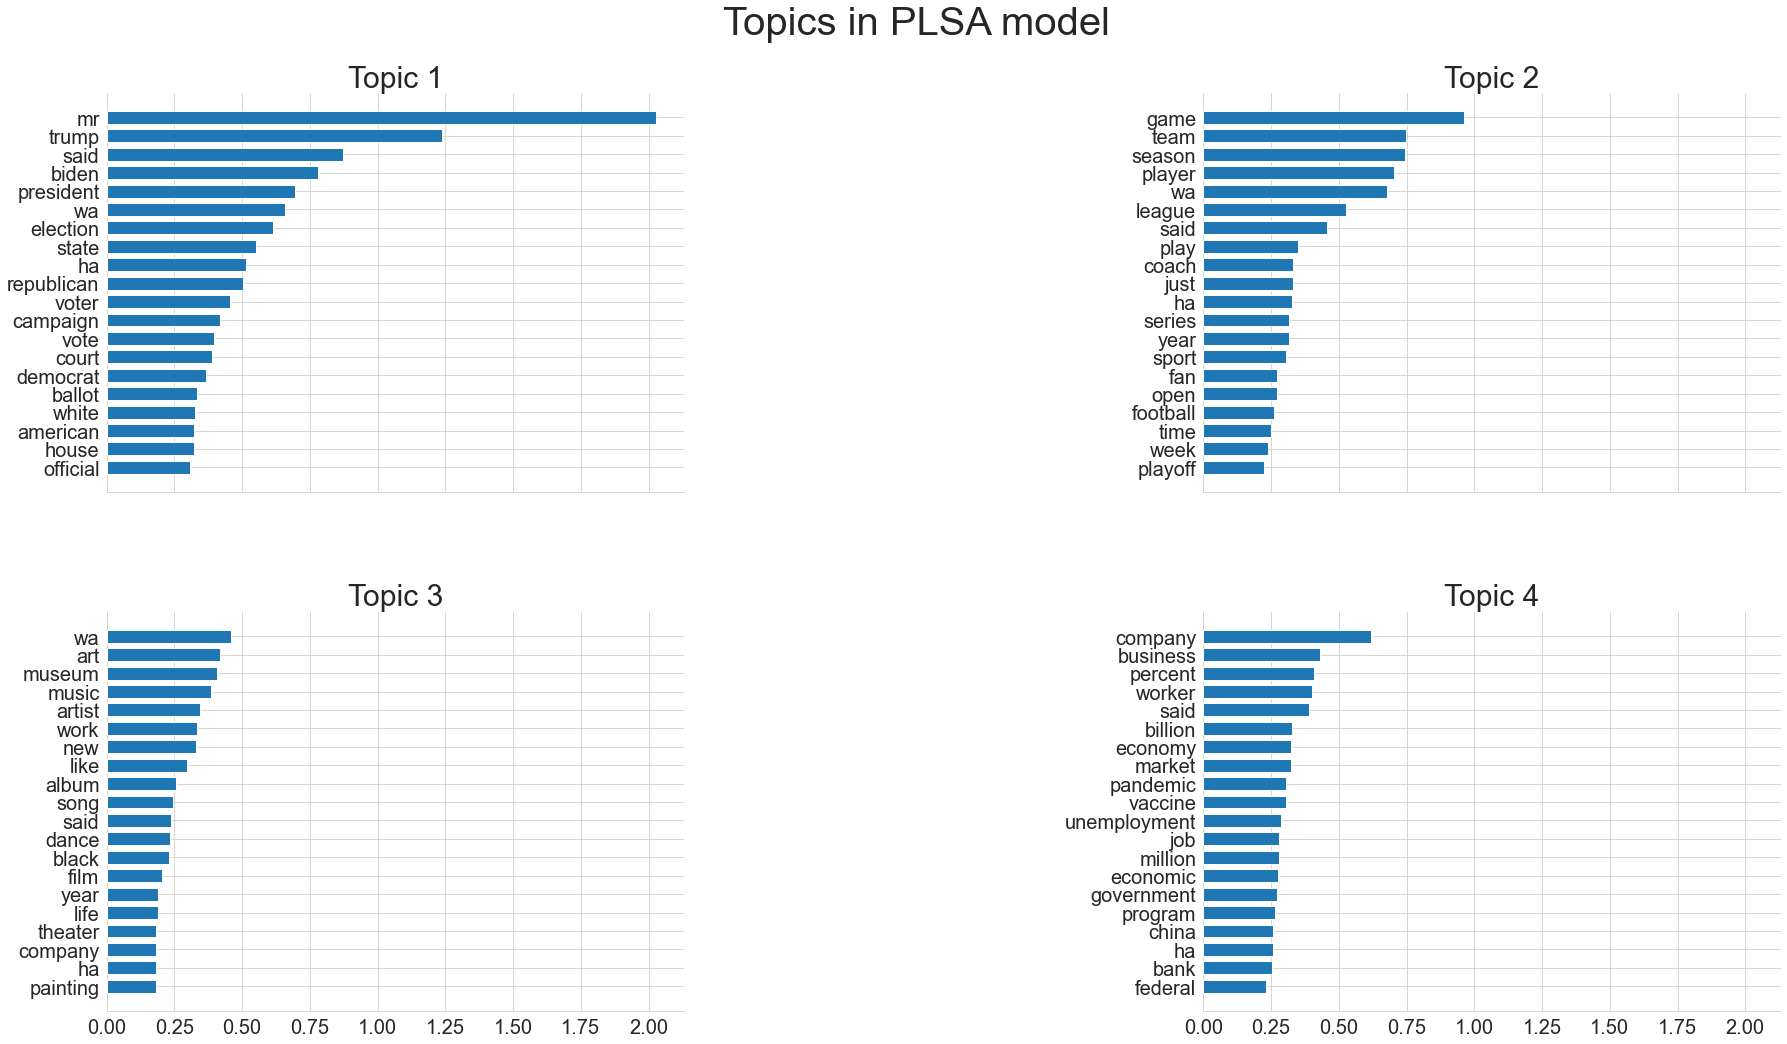

In [ ]:
plot_top_words(result_plsa[0][0], result_plsa[2][0], 20,
               'Topics in PLSA model', xx=2, yy=2)


Ключевые слова достаточно точно описывают имеющиеся исходные 4 категории.

#### Поиск соответствий

In [ ]:
def nmf_topics(model, feat_names, n_top_words, num_topics):
    word_dict = []

    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-n_top_words-1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict.append(words)
    return word_dict


**Ground truth категории : 'sport', 'buisness', 'art', 'politics'**

In [ ]:
texts_tokenize_eng  = [article.split() for article in texts]
dictionary_eng = Dictionary(texts_tokenize_eng)
corpus_eng = [dictionary_eng.doc2bow(text) for text in texts_tokenize_eng]

In [ ]:
model_w2v = gensim.models.Word2Vec(texts_tokenize_eng)
word_vectors = model_w2v.wv

In [ ]:
topn_words = nmf_topics(result_plsa[0][0], result_plsa[2][0], 20, 4)

Категория политика:

In [ ]:
topn_words[0]

['mr',
 'trump',
 'said',
 'biden',
 'president',
 'wa',
 'election',
 'state',
 'ha',
 'republican',
 'voter',
 'campaign',
 'vote',
 'court',
 'democrat',
 'ballot',
 'white',
 'american',
 'house',
 'official']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[0], ['politics'])
print(f"{similarity:.4f}")

0.1945


Категория спорт:

In [ ]:
topn_words[1]

['game',
 'team',
 'season',
 'player',
 'wa',
 'league',
 'said',
 'play',
 'coach',
 'just',
 'ha',
 'series',
 'year',
 'sport',
 'fan',
 'open',
 'football',
 'time',
 'week',
 'playoff']

In [ ]:

similarity = word_vectors.n_similarity(topn_words[1], ['sport'])
print(f"{similarity:.4f}")


0.3216


Категория арт:

In [ ]:
topn_words[2]

['wa',
 'art',
 'museum',
 'music',
 'artist',
 'work',
 'new',
 'like',
 'album',
 'song',
 'said',
 'dance',
 'black',
 'film',
 'year',
 'life',
 'theater',
 'company',
 'ha',
 'painting']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[2], ['art'])
print(f"{similarity:.4f}")

0.5768


Категория бизнес:

In [ ]:
topn_words[3]

['company',
 'business',
 'percent',
 'worker',
 'said',
 'billion',
 'economy',
 'market',
 'pandemic',
 'vaccine',
 'unemployment',
 'job',
 'million',
 'economic',
 'government',
 'program',
 'china',
 'ha',
 'bank',
 'federal']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[3], ['business'])
print(f"{similarity:.4f}")

0.5658


Коэффициенты схожести категорий с топиками неплохие.

**Сравнение тегов и найденных тем**

In [ ]:
data = []
for i in range(len(topn_words)):
    data.append([topn_words[i], all_tags_processed, word_vectors.n_similarity(topn_words[i], all_tags_processed)])
pd.DataFrame(data, columns=['Topics in model', 'all_tags_processed', 'similarity'])

Topics in model  \
0  [mr, trump, said, biden, president, wa, election, state, ha, republican, voter, campaign, vote, court, democrat, ballot, white, american, house, official]                     
1  [game, team, season, player, wa, league, said, play, coach, just, ha, series, year, sport, fan, open, football, time, week, playoff]                                           
2  [wa, art, museum, music, artist, work, new, like, album, song, said, dance, black, film, year, life, theater, company, ha, painting]                                           
3  [company, business, percent, worker, said, billion, economy, market, pandemic, vaccine, unemployment, job, million, economic, government, program, china, ha, bank, federal]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       all_tags_processed  \
0  [australia, amazon, com, inc, netflix, inc, television, movie, pop, and, rock, music, theater, bar, and, nightclub, coronavirus, reopenings, coronavirus, 2019, birdland, manhattan, ny, com, club, cumming, manhattan, ny, bar, don, tell, mama, feinstein, 54, below, manhattan, ny, music, venue, joe, pub, manhattan, ny, restaurant, public, theater, cumming, alan, starlite, tammy, faye, penny, arcade, billy, douglas, natalie, singer, dancing, graham, martha, dance, co, cunningham, merce, eilber, janet, pop, and, rock, music, gale, riley, 1986, 2020, power, trip, music, group, quarantine, life, and, culture, art, sign, and, signage, park, and, other, recreation, area, studio, museum, in, harlem, museum, bass, chloe, exhibit, dancing, ...]   
1  [australia, amazon, com, inc, netflix, inc, television, movie, pop, and, rock, music, theater, bar, and, nightclub, coronavirus, reopenings, coronavirus, 2019, birdland, manhattan, ny, com, club, cumming, manhattan, ny, bar, don, tell, mama, feinstein, 54, below, manhattan, ny, music, venue, joe, pub, manhattan, ny, restaurant, public, theater, cumming, alan, starlite, tammy, faye, penny, arcade, billy, douglas, natalie, singer, dancing, graham, martha, dance, co, cunningham, merce, eilber, janet, pop, and, rock, music, gale, riley, 1986, 2020, power, trip, music, group, quarantine, life, and, culture, art, sign, and, signage, park, and, other, recreation, area, studio, museum, in, harlem, museum, bass, chloe, exhibit, dancing, ...]   
2  [australia, amazon, com, inc, netflix, inc, television, movie, pop, and, rock, music, theater, bar, and, nightclub, coronavirus, reopenings, coronavirus, 2019, birdland, manhattan, ny, com, club, cumming, manhattan, ny, bar, don, tell, mama, feinstein, 54, below, manhattan, ny, music, venue, joe, pub, manhattan, ny, restaurant, public, theater, cumming, alan, starlite, tammy, faye, penny, arcade, billy, douglas, natalie, singer, dancing, graham, martha, dance, co, cunningham, merce, eilber, janet, pop, and, rock, music, gale, riley, 1986, 2020, power, trip, music, group, quarantine, life, and, culture, art, sign, and, signage, park, and, other, recreation, area, studio, museum, in, harlem, museum, bass, chloe, exhibit, dancing, ...]   
3  [australia, amazon, com, inc, netflix, inc, television, movie, pop, and, rock, music, theater, bar, and, nightclub, coronavirus, reopenings, coronavirus, 2019, birdland, manhattan, ny, com, club, cumming, manhattan, ny, bar, don, tell, mama, feinstein, 54, below, m

Коэффициенты схожести тегов с топиками варьируются от 0.42 до 0.56, что является хорошим результатом.

### Russian-language dataset

Векторизуем с помощью TfidfVectorizer и натренируем 4 модели (с количеством топиков 14, 20, 40, 46 - как и у LDA) NMF(beta_loss = 'kullback-leibler').

In [ ]:
vectorizer=TfidfVectorizer(min_df=5, max_df=0.4)
train_tfidf = vectorizer.fit_transform(df['filtered_text'])
num_topics = 14
model_plsa_14 = NMF(n_components = num_topics, beta_loss = 'kullback-leibler', solver = 'mu')
model_plsa_14.fit(train_tfidf)
num_topics = 20
model_plsa_20 = NMF(n_components = num_topics, beta_loss = 'kullback-leibler', solver = 'mu')
model_plsa_20.fit(train_tfidf)
num_topics = 40
model_plsa_40 = NMF(n_components = num_topics, beta_loss = 'kullback-leibler', solver = 'mu')
model_plsa_40.fit(train_tfidf)
num_topics = 46
model_plsa_46 = NMF(n_components = num_topics, beta_loss = 'kullback-leibler', solver = 'mu')
model_plsa_46.fit(train_tfidf)

NMF(alpha=0.0, beta_loss='kullback-leibler', init=None, l1_ratio=0.0,
    max_iter=200, n_components=46, random_state=None, shuffle=False,
    solver='mu', tol=0.0001, verbose=0)

In [ ]:
def get_nmf_topics(model, n_top_words, num_topics):
    feat_names = vectorizer.get_feature_names()
    word_dict = {}
    for i in range(num_topics): 
        words_ids = model.components_[i].argsort()[:-n_top_words-1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic #'+'{:02d}'.format(i+1)] = words
    return pd.DataFrame(word_dict)

Рассмотрим ключевые слова топиков для каждой модели:

**PLSA/NMF 14 topics**

In [ ]:
get_nmf_topics(model_plsa_14, 5, 14)

Topic #01  Topic #02  Topic #03  ... Topic #12    Topic #13    Topic #14
0      россия       дело        ufc  ...     рубль      военный  спортсменка
1       стать        суд       боец  ...      банк       ракета  олимпийский
2      страна    ефремов   поединок  ...    тысяча  космический    чемпионка
3  российский  задержать     победа  ...   миллион      самолёт         игра
4       ранее      актёр  спортсмен  ...    деньга      корабль   тутберидзе

[5 rows x 14 columns]

**PLSA/NMF 20 topics**

In [ ]:
get_nmf_topics(model_plsa_20, 5, 20)

Topic #01  Topic #02 Topic #03  ...  Topic #18   Topic #19 Topic #20
0      россия    ефремов       ufc  ...  экономика     протест       суд
1       стать      актёр      боец  ...     страна  белоруссия      дело
2       новый      ефрем  поединок  ...     доллар      выборы  сафронов
3  российский       дело    победа  ...        ввп   лукашенко   адвокат
4      работа  задержать   чемпион  ...     валюта   навальный    бывший

[5 rows x 20 columns]

**PLSA/NMF 40 topics**

In [ ]:
get_nmf_topics(model_plsa_40, 5, 40)

Topic #01 Topic #02   Topic #03  ... Topic #38  Topic #39  Topic #40
0   процент   ефремов     команда  ...    смерть      китай       дело
1    россия     актёр        матч  ...    летний        сша  уголовный
2     стать     ефрем        клуб  ...    бывший  китайский  задержать
3     новый       дтп      тренер  ...    ноябрь        вор         рф
4     число    михаил  российский  ...   умереть      закон     статья

[5 rows x 40 columns]

**PLSA/NMF 46 topics**

In [ ]:
get_nmf_topics(model_plsa_46, 5, 46)

Topic #01 Topic #02  Topic #03  ...    Topic #44 Topic #45       Topic #46
0   процент   ефремов    команда  ...    навальный   продукт         самолёт
1    россия     актёр       матч  ...   обнаружить      игра           пилот
2  пандемия     ефрем       клуб  ...         тело   консоль  антидопинговый
3     рубль       дтп  футболист  ...      наслать   напиток            игра
4    тысяча    михаил    сборная  ...  марцинкевич  алкоголь    соревнование

[5 rows x 46 columns]

Визуально ключевые слова для топиков более точны, чем у LDA.

Подсчитаем coherence(c_v):

In [ ]:
def nmf_coherence(nmf):
  c_v = metric_coherence_gensim(measure='c_v',
                                      top_n=10, 
                                      topic_word_distrib=nmf.components_, 
                                      dtm=train_tfidf, 
                                      vocab=np.array([x for x in vectorizer.vocabulary_.keys()]),
                                      texts=common_texts)
  score = np.mean(c_v)
  return score

In [ ]:
data = []
models = [model_plsa_14,model_plsa_20,model_plsa_40,model_plsa_46]
for i in range(4):
    data.append([models[i], nmf_coherence(models[i])])
pd.DataFrame(data, columns=['Model', 'coherence=c_v'])

Model  coherence=c_v
0  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.553032
1  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.555883
2  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.550371
3  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.539209

Наибольший coherence у второй модели (число топиков 20). В целом неплохо и лучше, чем у LDA.

#### Визуализация лучшей модели

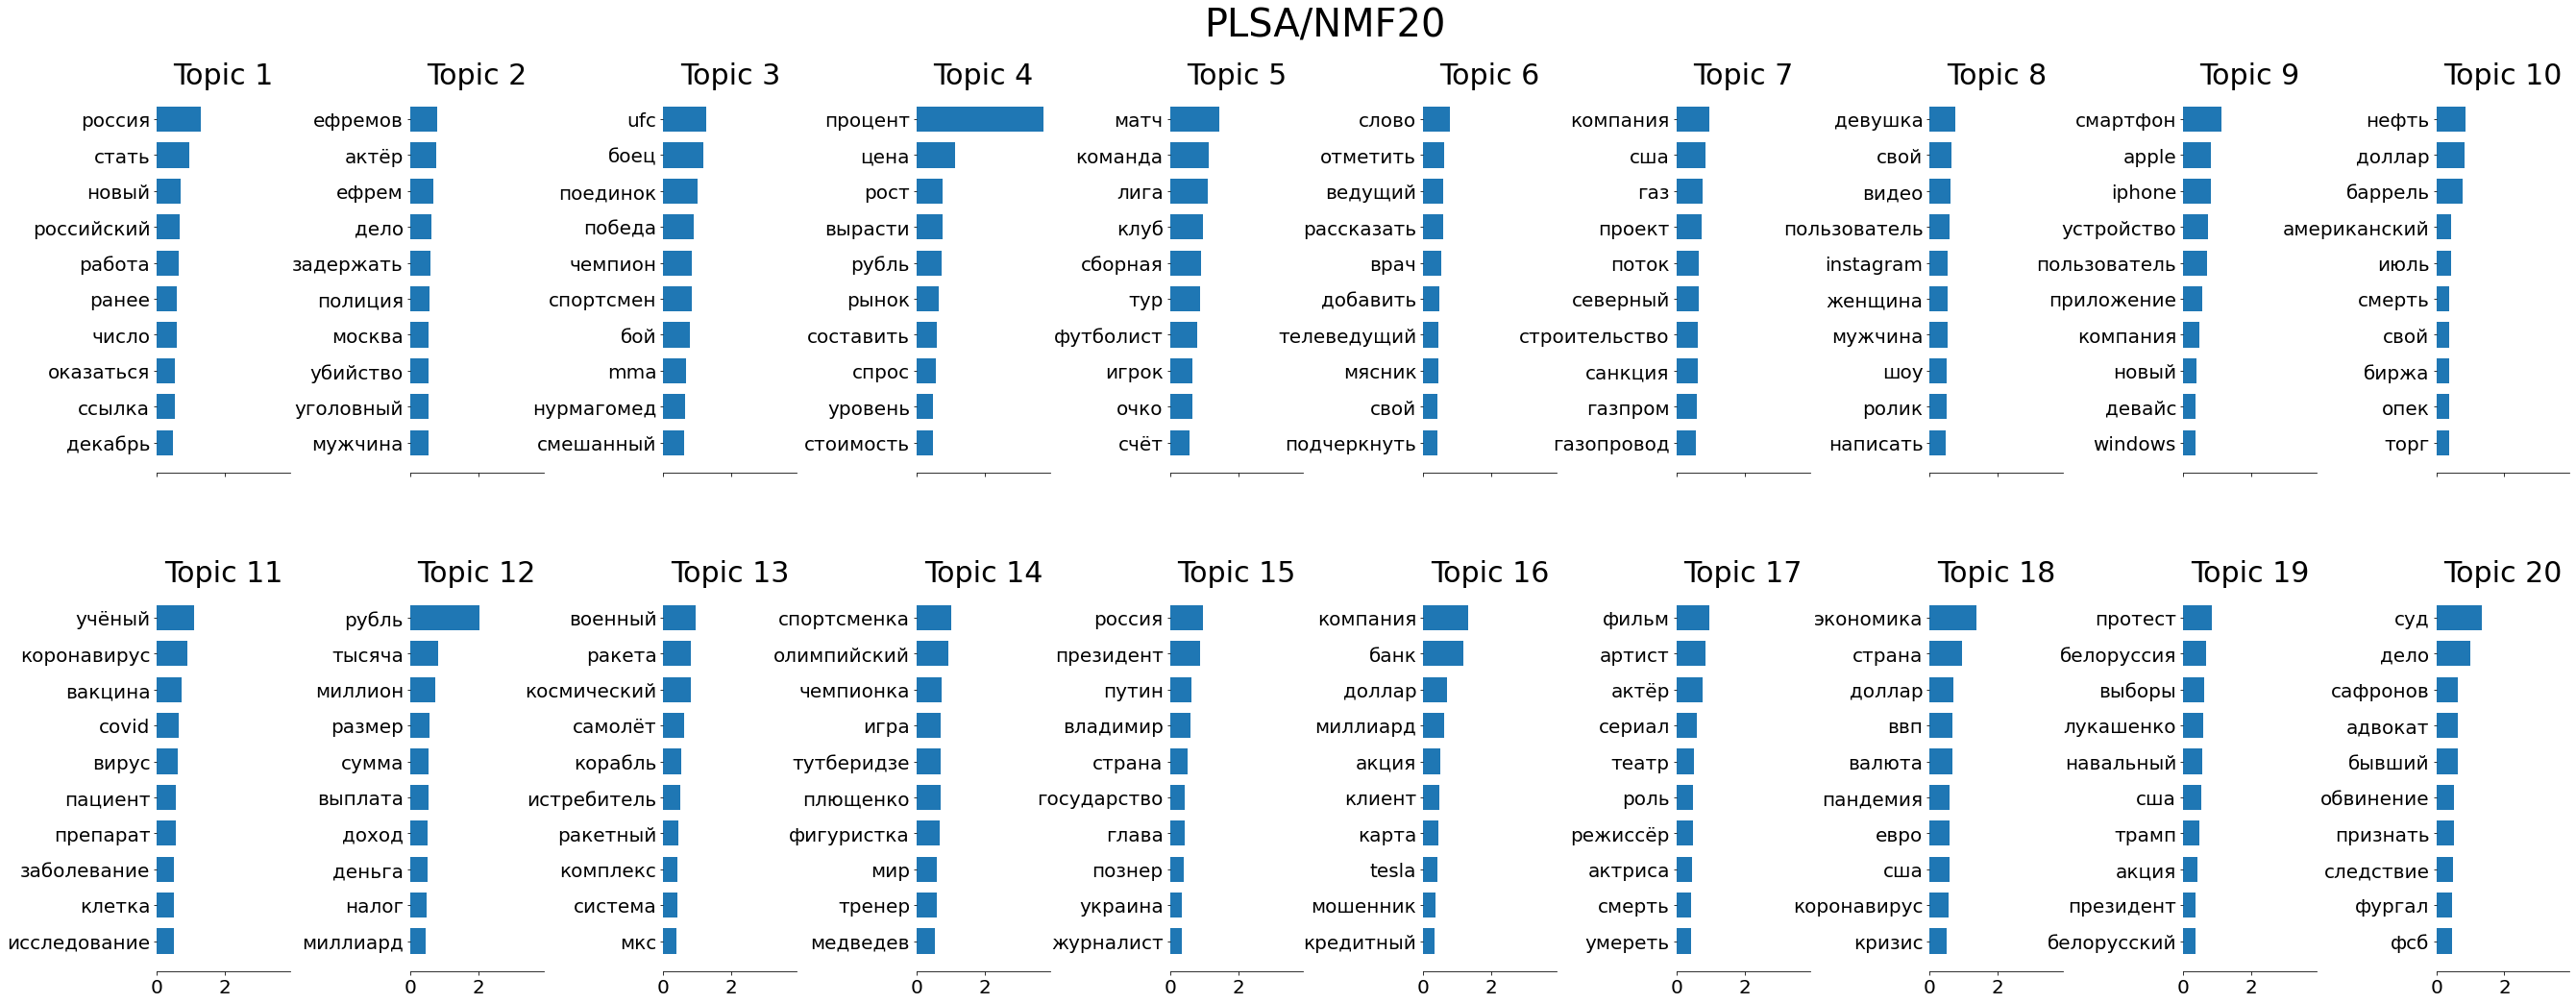

In [ ]:
plot_top_words(model_plsa_20, vectorizer.get_feature_names(), 10, 'PLSA/NMF20')

Topic 2 и Topic 3 встречаются с примерно таким же набором ключевых слов в LDA (некоторые топики тоже схожи).

#### Поиск соответствий

In [ ]:
def nmf_topics(model, n_top_words, num_topics):
    feat_names = vectorizer.get_feature_names()
    word_dict = []

    for i in range(num_topics): 
        words_ids = model.components_[i].argsort()[:-n_top_words-1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict.append(words)
    return word_dict 

**Ground truth категории : 'экономика', 'наука', 'культура', 'медиа', 'спорт', 'сила'**

**Найденная тема о UFC связана с категорией спорт**:

In [ ]:
topn_words = nmf_topics(model_plsa_20, 10, 20)

In [ ]:
topn_words[2]

['ufc',
 'боец',
 'поединок',
 'победа',
 'чемпион',
 'спортсмен',
 'бой',
 'mma',
 'нурмагомед',
 'смешанный']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[2], ['спорт'])
print(f"{similarity:.4f}")

0.3958


**Найденная тема о военных разработках связана с категорией сила (силовые структуры)**:

In [ ]:
topn_words[12]

['военный',
 'ракета',
 'космический',
 'самолёт',
 'корабль',
 'истребитель',
 'ракетный',
 'комплекс',
 'система',
 'мкс']

In [ ]:
similarity = word_vectors.n_similarity(topn_words[12], ['сила'])
print(f"{similarity:.4f}")

0.4300


**Сравнение тегов и найденных тем**

In [ ]:
data = []
for i in range(len(topn_words)):
    data.append([topn_words[i], all_tags_processed, word_vectors.n_similarity(topn_words[i], all_tags_processed)])
pd.DataFrame(data, columns=['Topics in model', 'all_tags_processed', 'similarity'])

Topics in model  ... similarity
0   [россия, стать, новый, российский, работа, ран...  ...   0.314241
1   [ефремов, актёр, ефрем, дело, задержать, полиц...  ...   0.372200
2   [ufc, боец, поединок, победа, чемпион, спортсм...  ...   0.462913
3   [процент, цена, рост, вырасти, рубль, рынок, с...  ...   0.151959
4   [матч, команда, лига, клуб, сборная, тур, футб...  ...   0.452294
5   [слово, отметить, ведущий, рассказать, врач, д...  ...   0.332548
6   [компания, сша, газ, проект, поток, северный, ...  ...   0.349052
7   [девушка, свой, видео, пользователь, instagram...  ...   0.266231
8   [смартфон, apple, iphone, устройство, пользова...  ...   0.182904
9   [нефть, доллар, баррель, американский, июль, с...  ...   0.330712
10  [учёный, коронавирус, вакцина, covid, вирус, п...  ...   0.143031
11  [рубль, тысяча, миллион, размер, сумма, выплат...  ...   0.153793
12  [военный, ракета, космический, самолёт, корабл...  ...   0.417196
13  [спортсменка, олимпийский, чемпионка, игра, ту...  ...   0.505058
14  [россия, президент, путин, владимир, страна, г...  ...   0.467939
15  [компания, банк, доллар, миллиард, акция, клие...  ...   0.261846
16  [фильм, артист, актёр, сериал, театр, роль, ре...  ...   0.416112
17  [экономика, страна, доллар, ввп, валюта, панде...  ...   0.241427
18  [протест, белоруссия, выборы, лукашенко, навал...  ...   0.407462
19  [суд, дело, сафронов, адвокат, бывший, обвинен...  ...   0.453633

[20 rows x 3 columns]

В среднем схожость тегов и ключевых слов (в топиках) варьируется от 0.3 до 0.40. По сравнению с LDA значения хуже.

## General conclusion

### English-language dataset

In [ ]:
data = []
for i in range(len(result_lda_eng[0])):
    data.append([result_lda_eng[0][i], result_lda_eng[1][i], result_lda_eng[2][i]])
pd.DataFrame(data, columns=['Model', 'coherence=c_w2v', 'coherence=c_v'])

Model  \
0  LdaModel(num_terms=61224, num_topics=4, decay=0.5, chunksize=2000)    
1  LdaModel(num_terms=61224, num_topics=20, decay=0.5, chunksize=2000)   
2  LdaModel(num_terms=61224, num_topics=40, decay=0.5, chunksize=2000)   
3  LdaModel(num_terms=61224, num_topics=60, decay=0.5, chunksize=2000)   

   coherence=c_w2v  coherence=c_v  
0  0.419814         0.422668       
1  0.586886         0.518221       
2  0.641821         0.507587       
3  0.669779         0.522984

In [ ]:
data = []
for i in range(len(result_plsa[0])):
    data.append([result_plsa[0][i], np.array(result_plsa[1][i]).mean()])
pd.DataFrame(data, columns=['Model', 'coherence=c_v'])

Model  \
0  NMF(beta_loss='kullback-leibler', n_components=4, solver='mu')    
1  NMF(beta_loss='kullback-leibler', n_components=20, solver='mu')   
2  NMF(beta_loss='kullback-leibler', n_components=40, solver='mu')   
3  NMF(beta_loss='kullback-leibler', n_components=60, solver='mu')   

   coherence=c_v  
0  0.739698       
1  0.695130       
2  0.689193       
3  0.688719

По coherence=с_v LDA проигрывает PLSA, это также можно заметить по ключевым словам топиков и по их значимости.

### Russian-language dataset

In [ ]:
data = []
models = [model_plsa_14,model_plsa_20,model_plsa_40,model_plsa_46]
for i in range(4):
    data.append([models[i], nmf_coherence(models[i])])
pd.DataFrame(data, columns=['Model', 'coherence=c_v'])

Model  coherence=c_v
0  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.553032
1  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.555883
2  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.550371
3  NMF(alpha=0.0, beta_loss='kullback-leibler', i...       0.539209

In [ ]:
data = []
models = [LDA14,LDA20,LDA40,LDA46]
for i in range(4):
    data.append([models[i], coherence_score_cv(models[i]),coherence_score(models[i])])
pd.DataFrame(data, columns=['Model', 'coherence=c_v', 'coherence=c_w2v'])

Model  ...  coherence=c_w2v
0  LdaModel(num_terms=67143, num_topics=14, decay...  ...         0.520585
1  LdaModel(num_terms=67143, num_topics=28, decay...  ...         0.502189
2  LdaModel(num_terms=67143, num_topics=32, decay...  ...         0.502328
3  LdaModel(num_terms=67143, num_topics=36, decay...  ...         0.496655

[4 rows x 3 columns]

И так, по coherence=с_v LDA проигрывает PLSA, это также можно заметить по ключевым словам топиков и по их значимости.